<a href="https://colab.research.google.com/github/rotembar22/customer-churn-prediction/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn Prediction

In [1]:
!pip install scikit-plot
!pip install seaborn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
pd.set_option('precision', 3)

# Data Visualisation Libraries
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


import seaborn as sns
sns.set_style('darkgrid')

# Statistics
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import scikitplot as skplt



# Load the data

In [53]:
df = pd.read_csv('/content/Churn_Modelling.csv')

print(df.shape)
df.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [54]:
# Drop uninformative columns
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


We dont have missing values


# Train-Test split

In [55]:
# Split the data with 80-20% ratio to train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Reset indexs after the split
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)



# EDA


### Target Variable: Exited

0    6356
1    1644
Name: Exited, dtype: int64


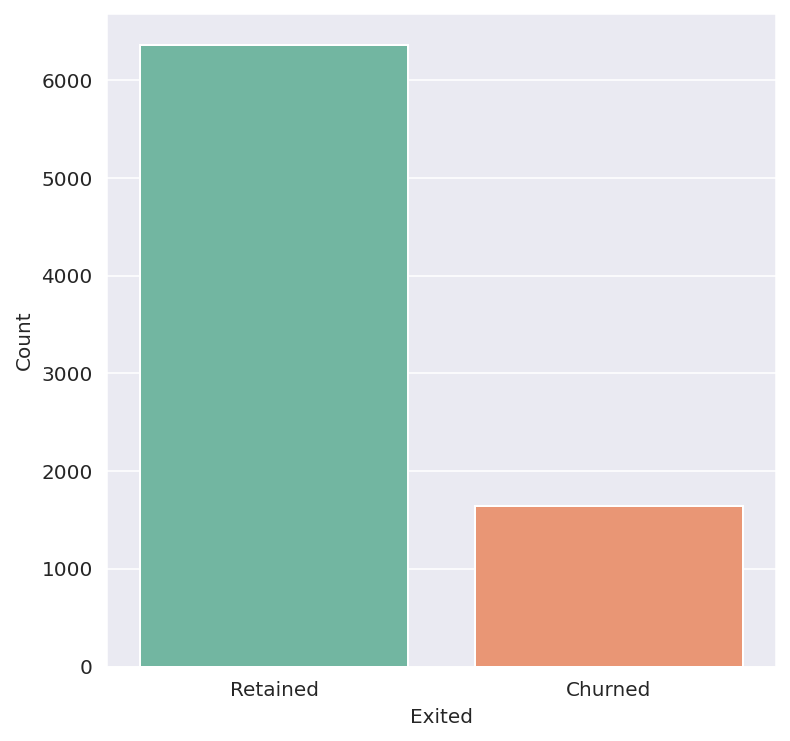

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='Exited', data=train_df,  ax=ax, palette= "Set2")
ax.set_xticklabels(['Retained', 'Churned'])
ax.set_ylabel('Count')

print(train_df.Exited.value_counts())

In [9]:
# Listing the continuous and the categoricals features
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

## Continuous Features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fafa5b4b910>,
      dtype=object)

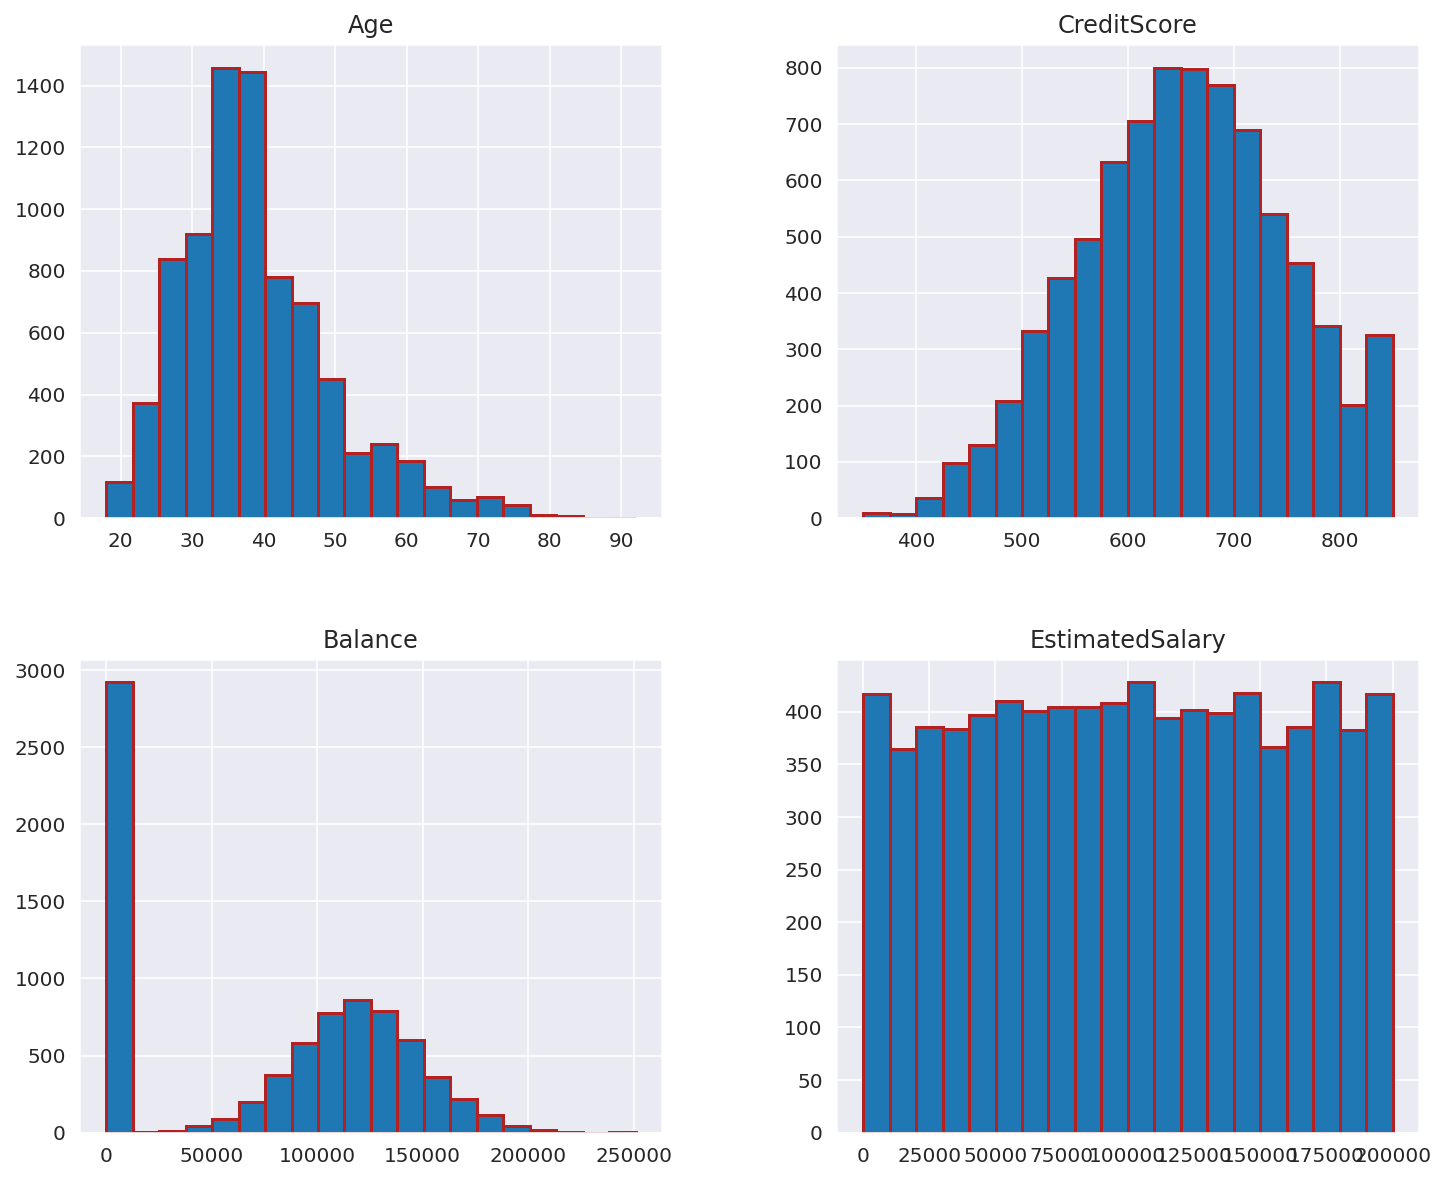

In [10]:
train_df[continuous].hist(figsize=(12, 10),bins=20,layout=(2, 2),edgecolor='firebrick',linewidth=1.5 )

- 'Age' is slightly tail-heavy, i.e. it extends more further to the right of the median than to the left,
- Most values for 'CreditScore' are above 600,
- If we ignore the first bin, 'Balance' follows a fairly normal distribution, and
- The distribution of 'EstimatedSalary' is more or less uniform and provides little information.



## Correlations heat-map

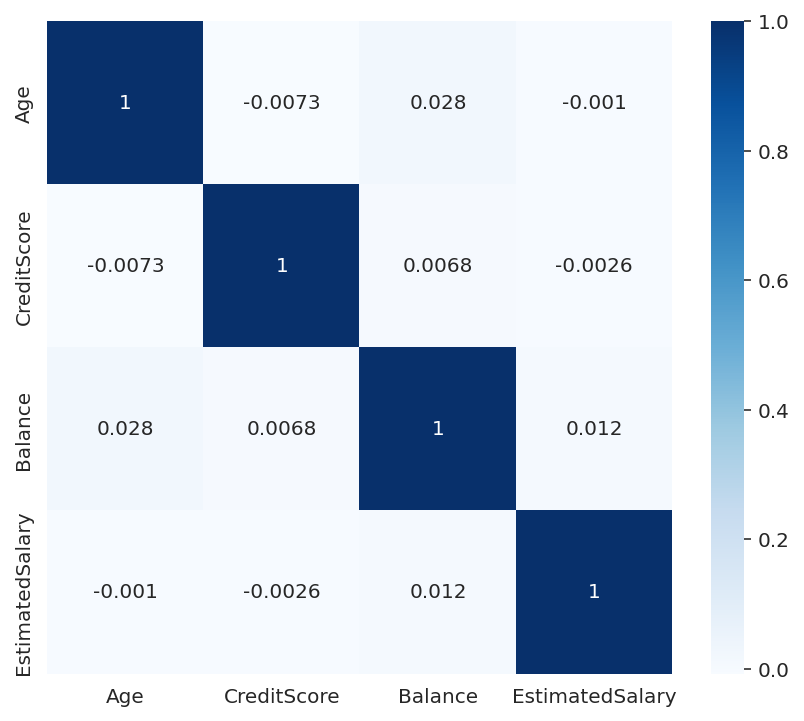

In [11]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(train_df[continuous].corr(), annot=True, cmap='Blues', ax=ax)

### Age

In [12]:
# Plot a histogram and boxplot for the churned and retained distributions for the specified feature

def plot_continuous(feature):
    df_func = train_df.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 7), sharex=True, gridspec_kw={'height_ratios': (.7, .3)})

    for df, label in zip([df_retained, df_churned], ['Retained', 'Churned']):
        sns.histplot(data=df, x=feature, bins=15, alpha=0.66, edgecolor='firebrick', label=label, kde=False, ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='Exited', data=df_func, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    plt.tight_layout()

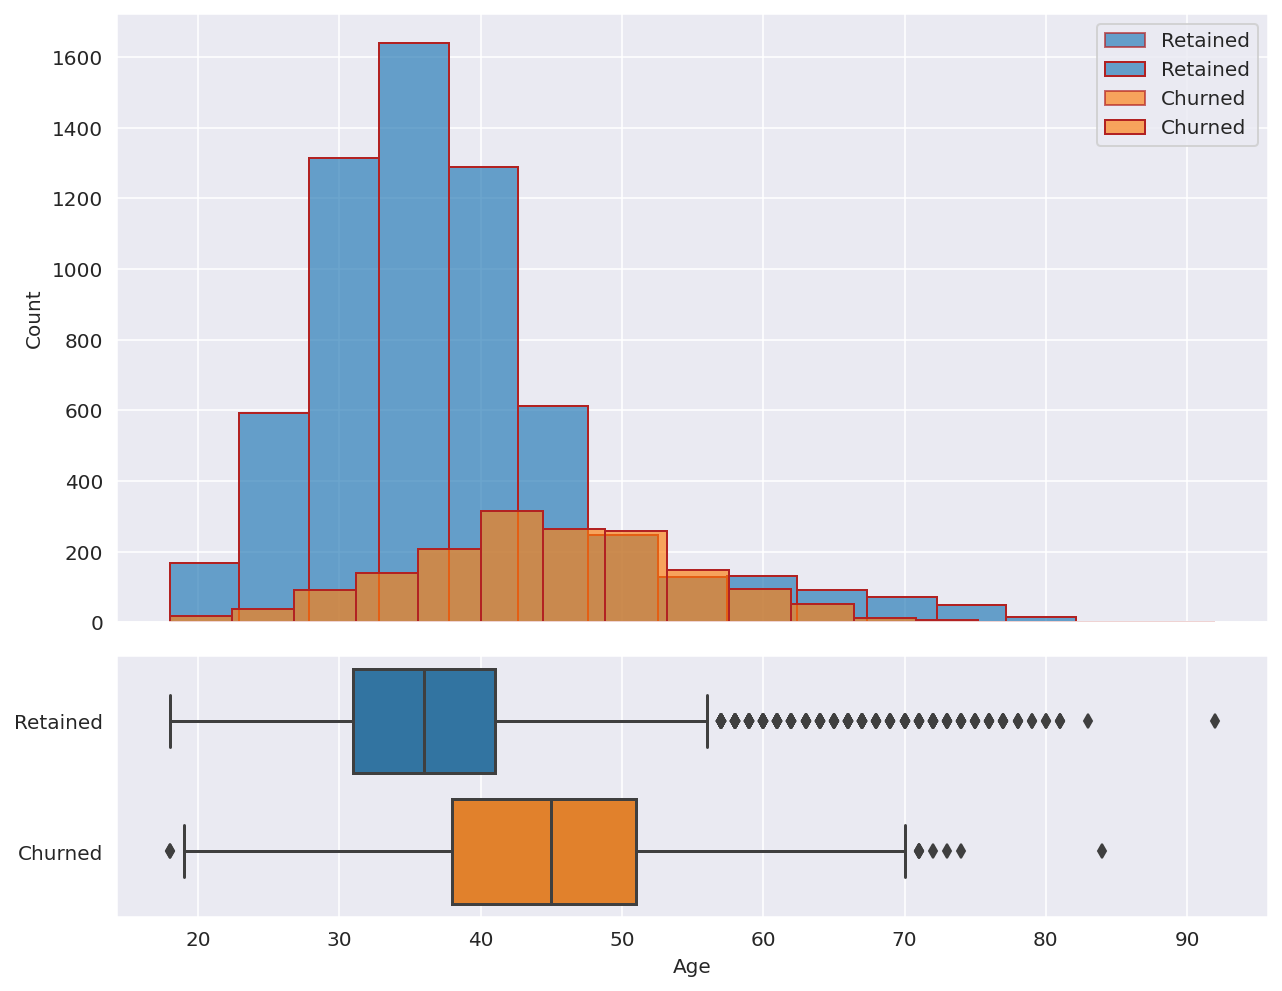

In [13]:
df_churned = train_df[train_df['Exited'] == 1]
df_retained = train_df[train_df['Exited'] == 0]

plot_continuous('Age')

### Credit Score

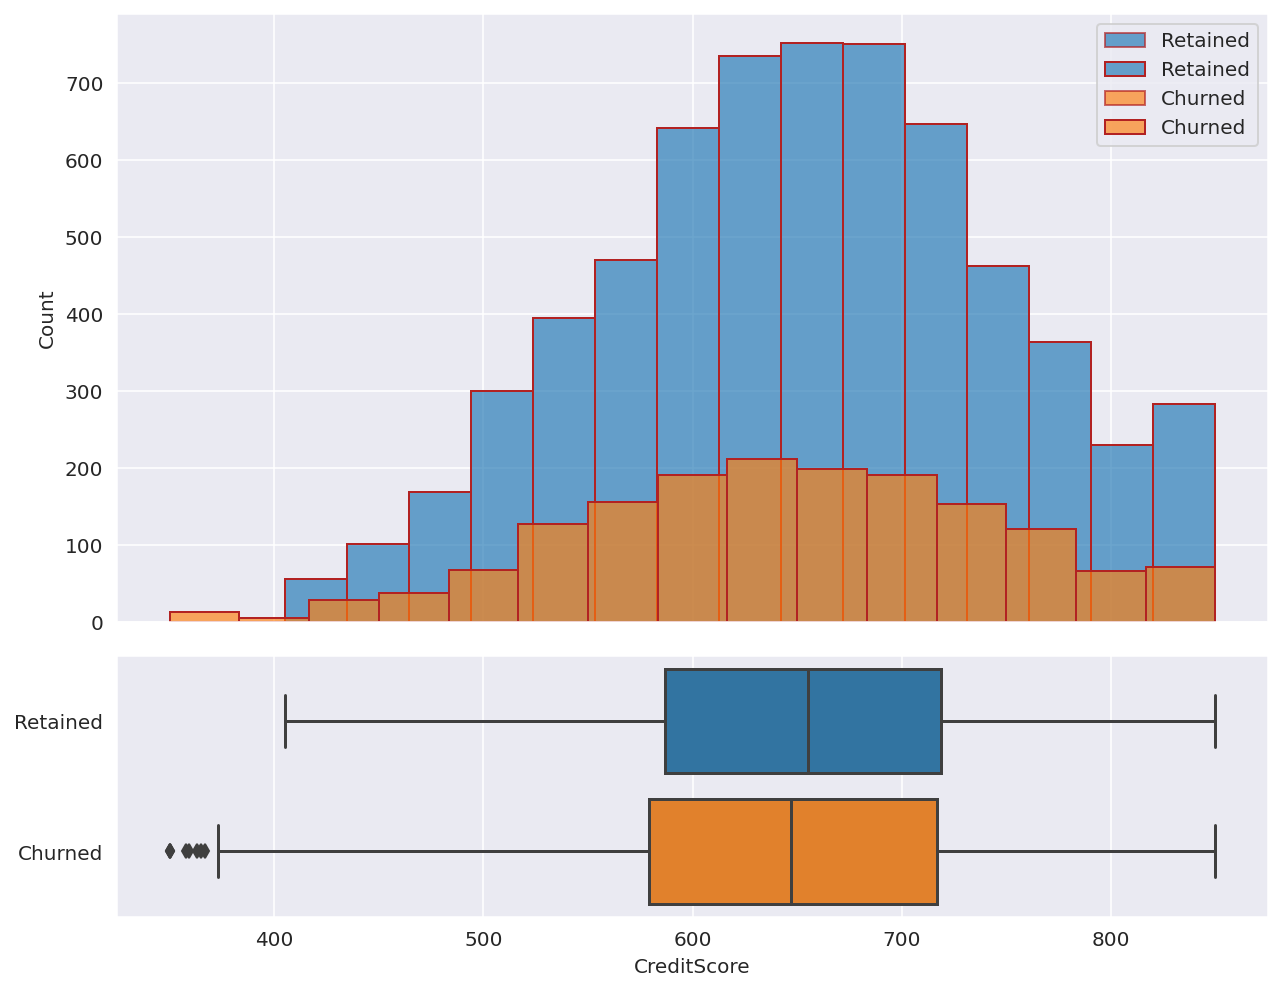

In [14]:
plot_continuous('CreditScore')

### Balance

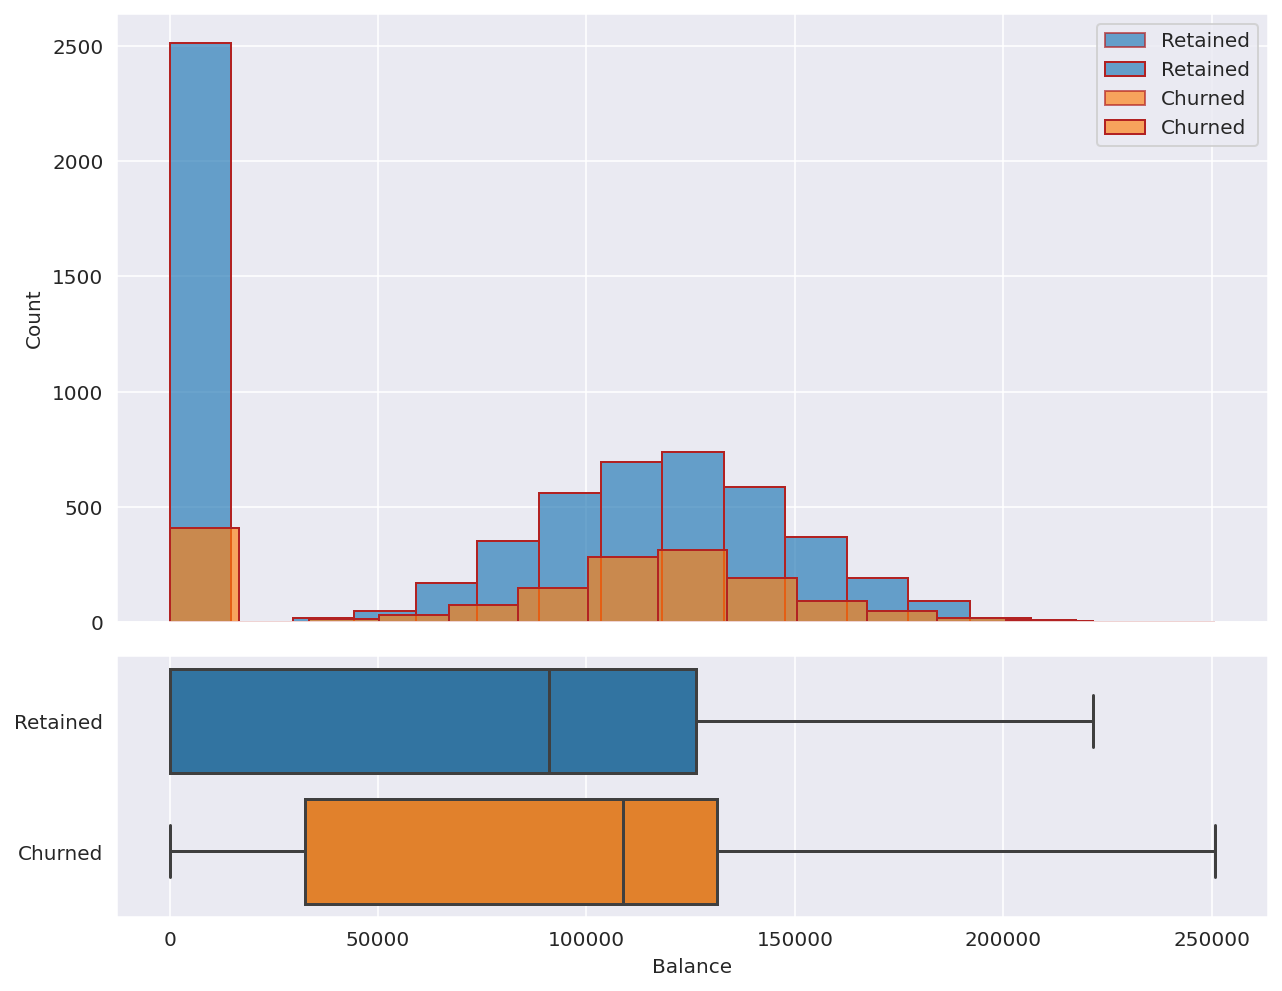

In [15]:
plot_continuous('Balance')

### Estimated Salary

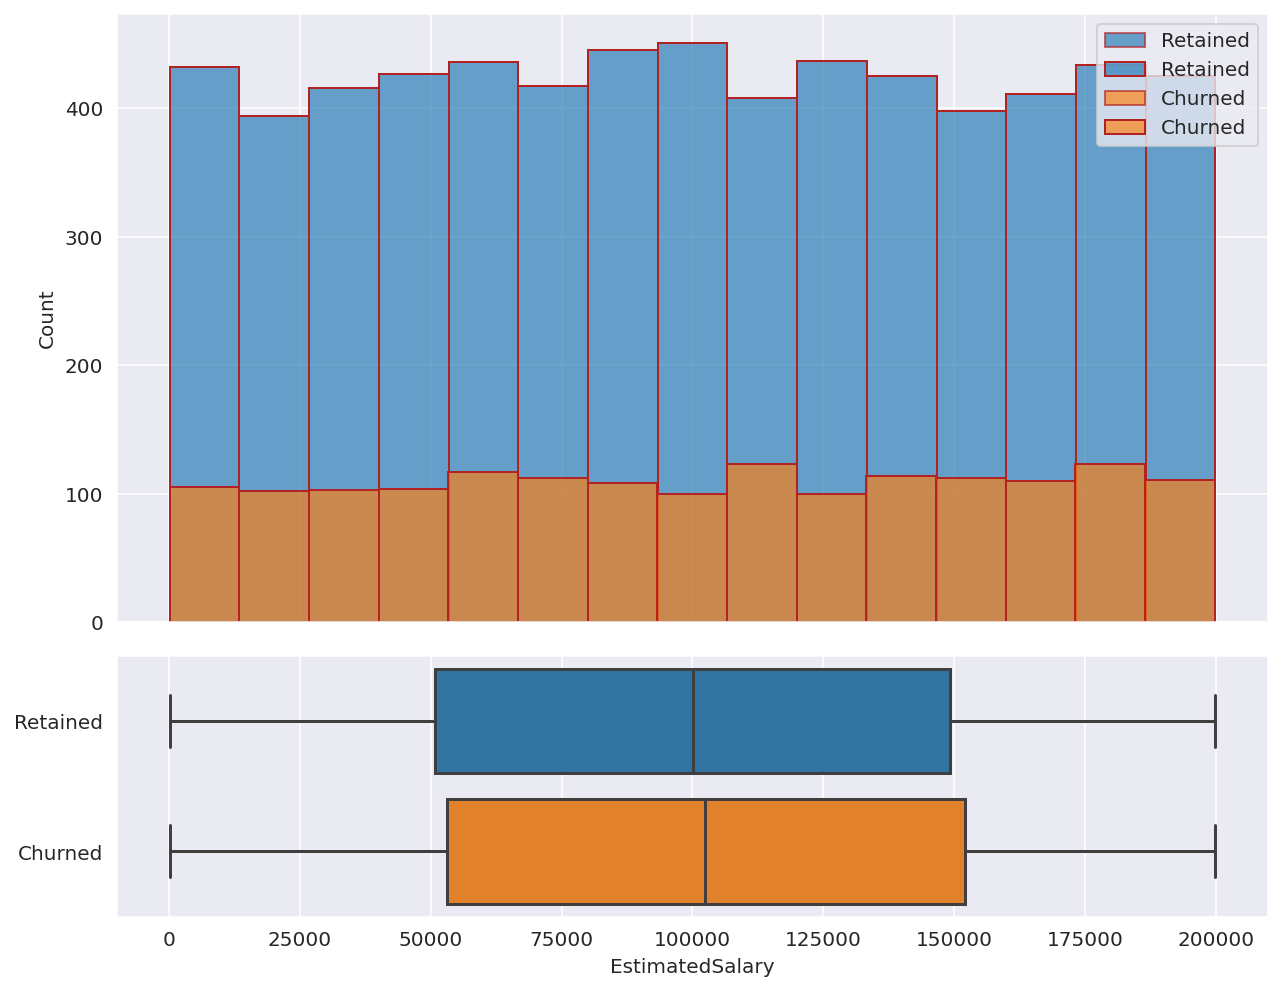

In [16]:
plot_continuous('EstimatedSalary')

Both churned and retained customers display a similar uniform distribution in their salaries. Consequently, we can conclude that salary doesn't have a significant effect on the likelihood to churn.

## Categorical Variables

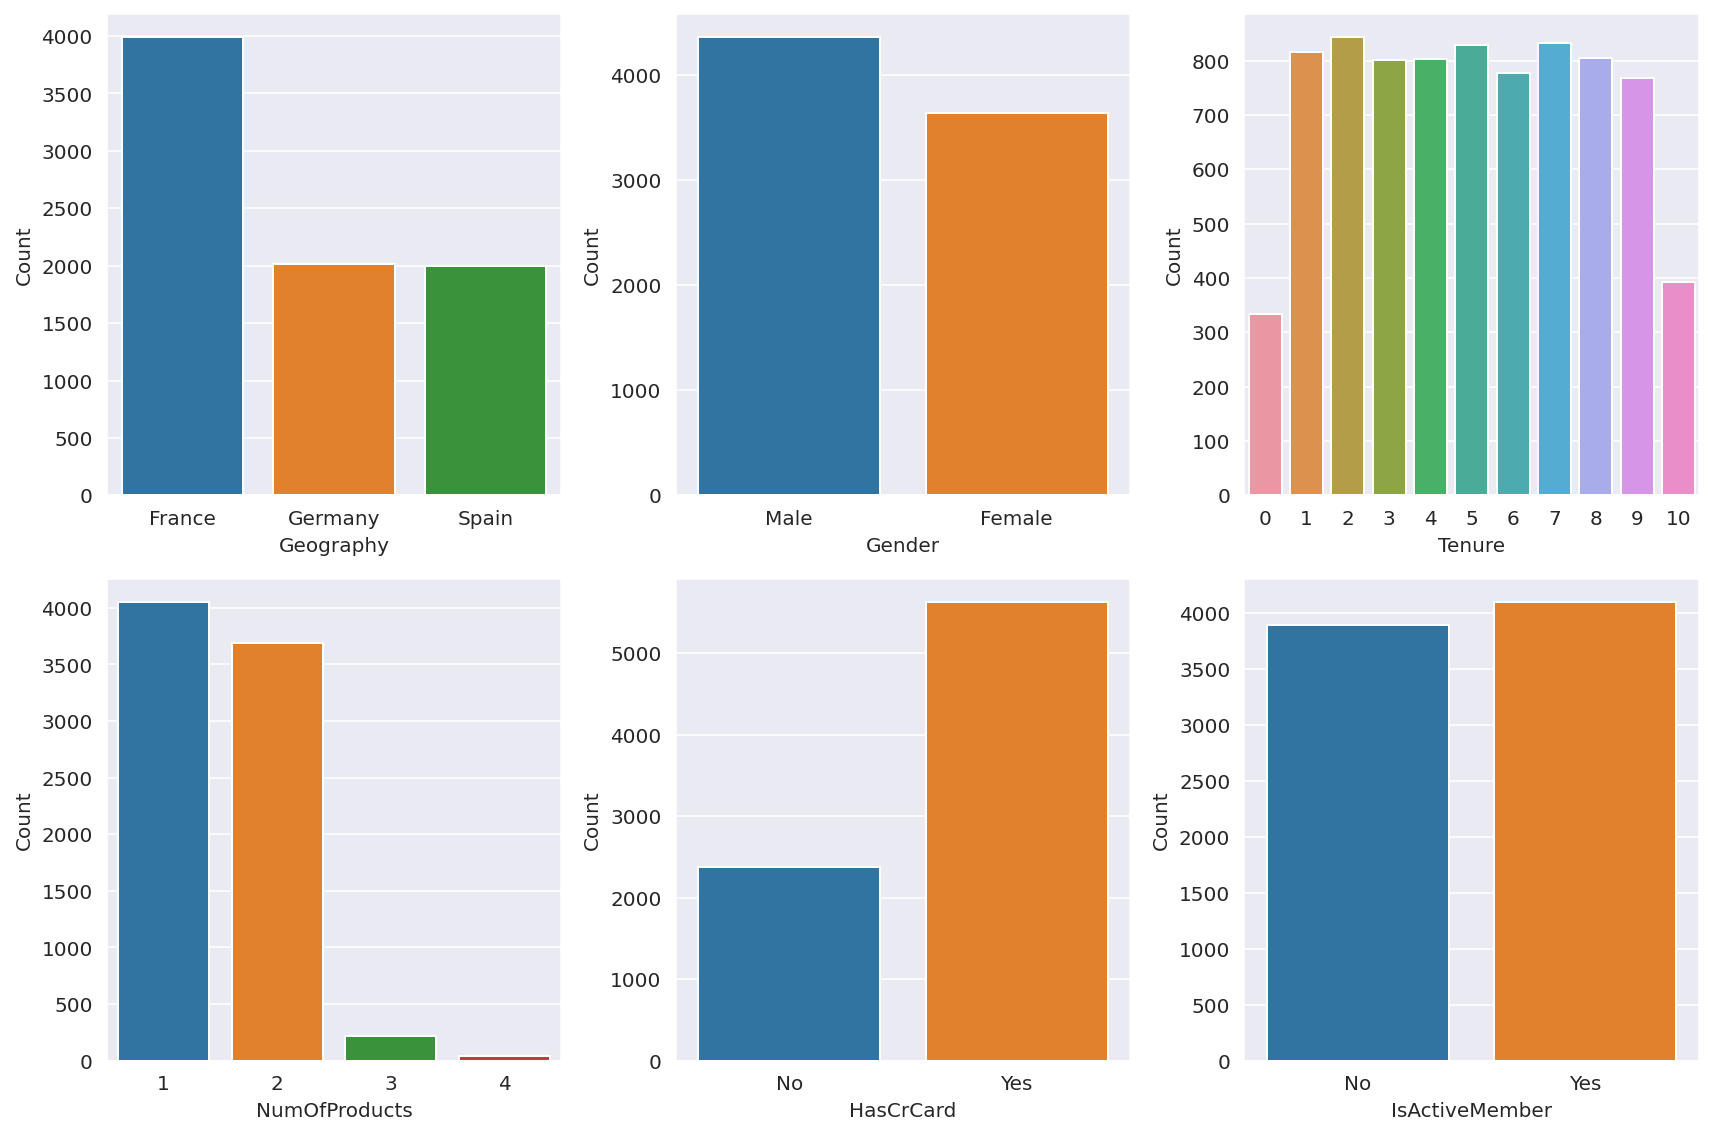

In [17]:
df_cat = train_df[categorical]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column, data=train_df)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

Important points:

- The bank has customers in three countries (France, Spain, and Germany). Most customers are in France.
- There are more male customers than females,
- Only a small percentage leaves within the first year. The count of customers in tenure years between 1 and 9 is almost the same,
- Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4,
- A significant majority of customers has a credit card, and
- Almost 50% of customers are not active.

### Geography

In [18]:
# For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate
def plot_categorical(feature):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(x=feature, hue='Exited', data=train_df, ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature, y='Exited', data=train_df, ax=ax2)
    ax2.set_ylabel('Churn rate')

    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout()

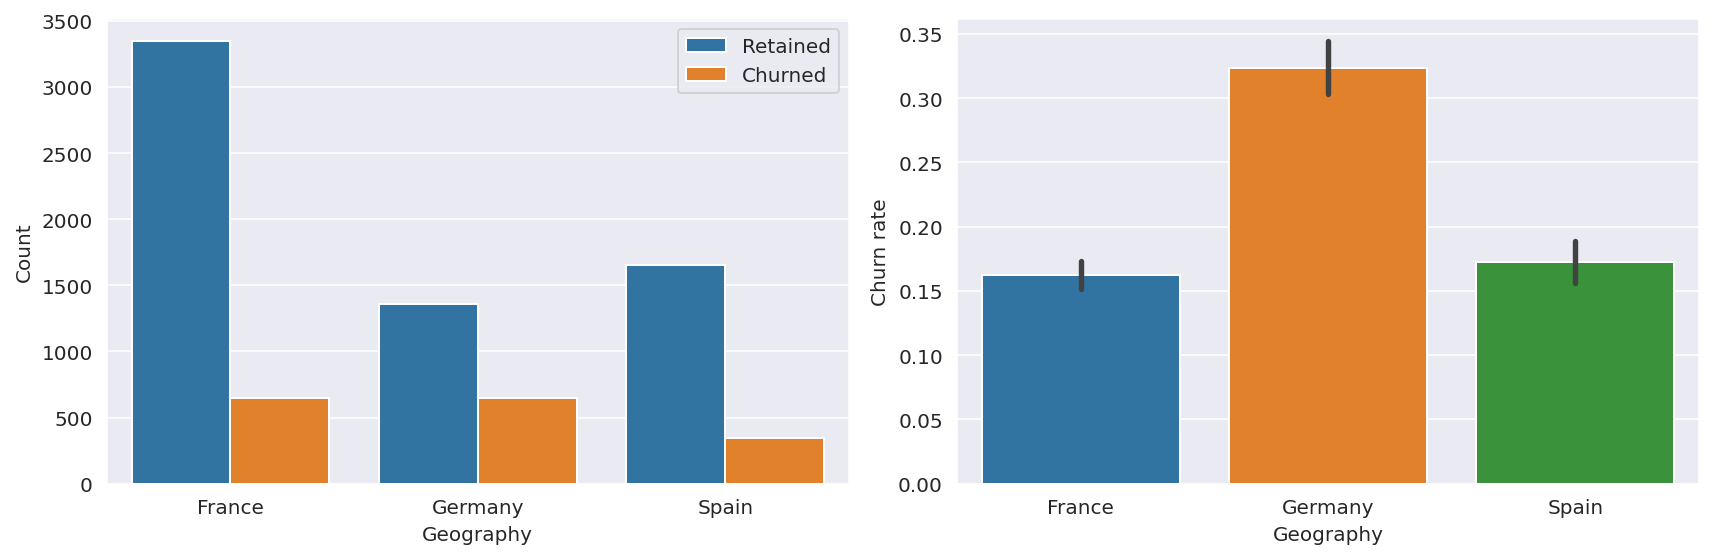

In [19]:
plot_categorical('Geography')

Customers in Germany are more likely to churn than customers in the other two countries (the churn rate is almost double compared to Spain and France). Many reasons could explain this finding, such as higher competition or different preferences for German customers.

### Gender

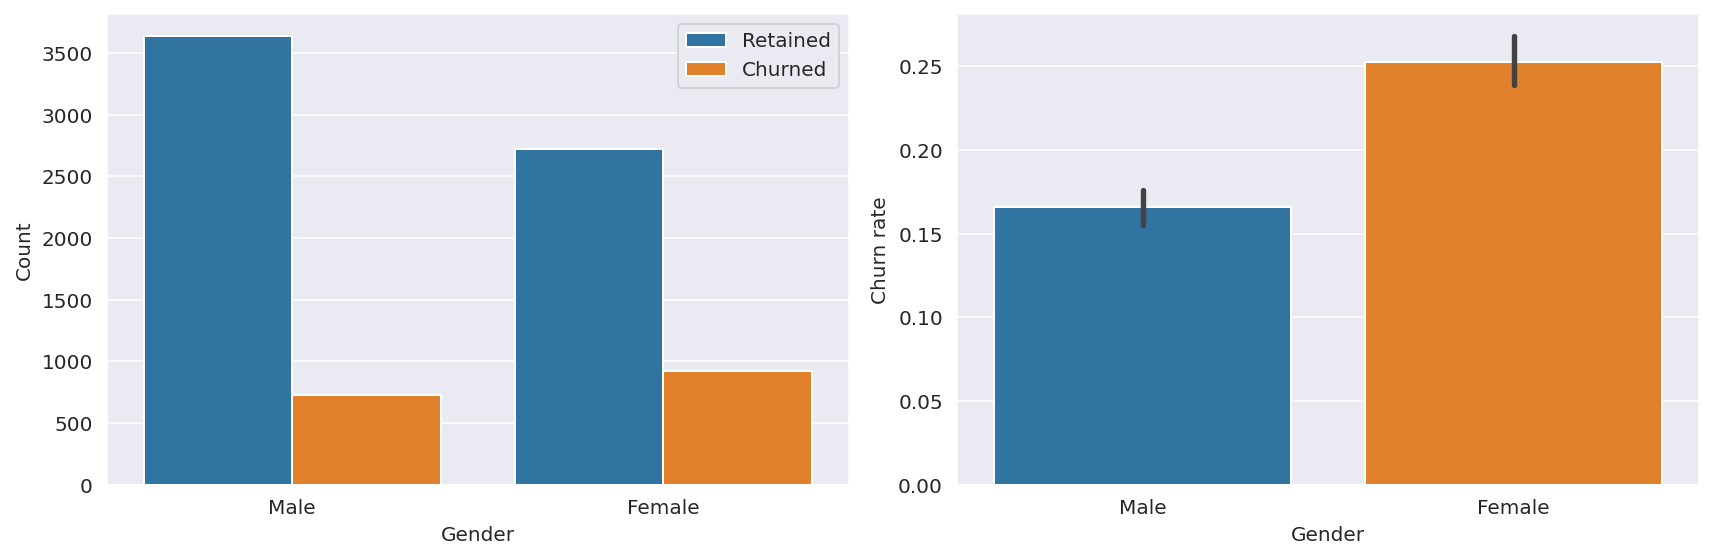

In [20]:
plot_categorical('Gender')

Female customers are more likely to churn.

### Tenure

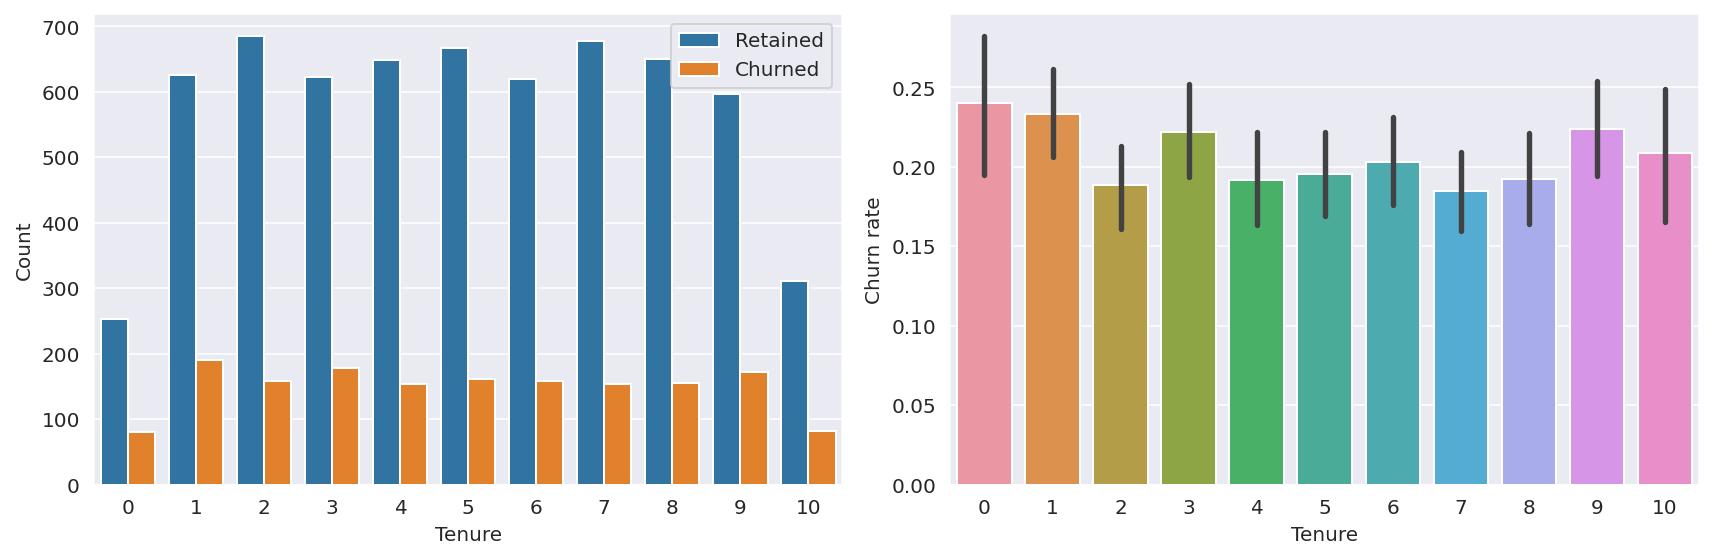

In [21]:
plot_categorical('Tenure')

The number of years (tenure) does not seem to affect the churn rate.

### Number of Products

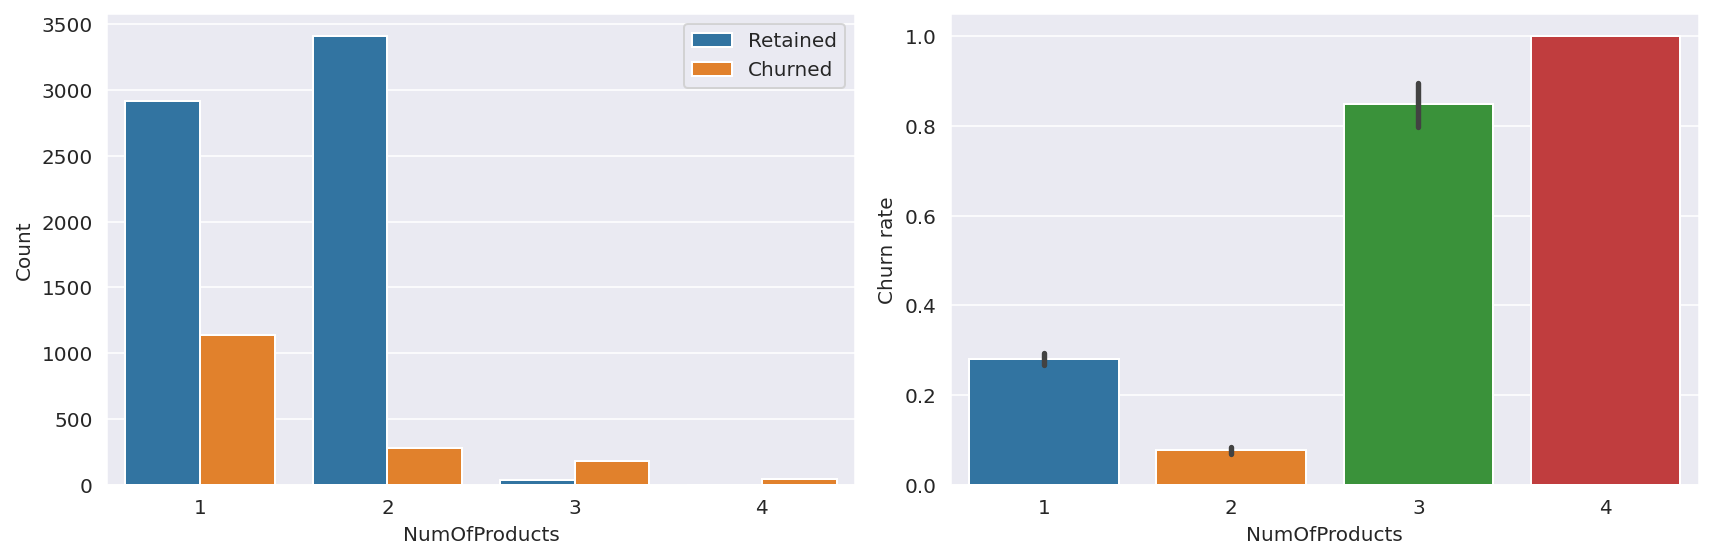

In [22]:
plot_categorical('NumOfProducts')

Interestingly, having 3 or 4 products significantly increases the likelihood of churn. I am not sure how to interpret this result. It could potentially mean that the bank cannot properly support customers with more products which in turn increases customer dissatisfaction.

### Card Holders

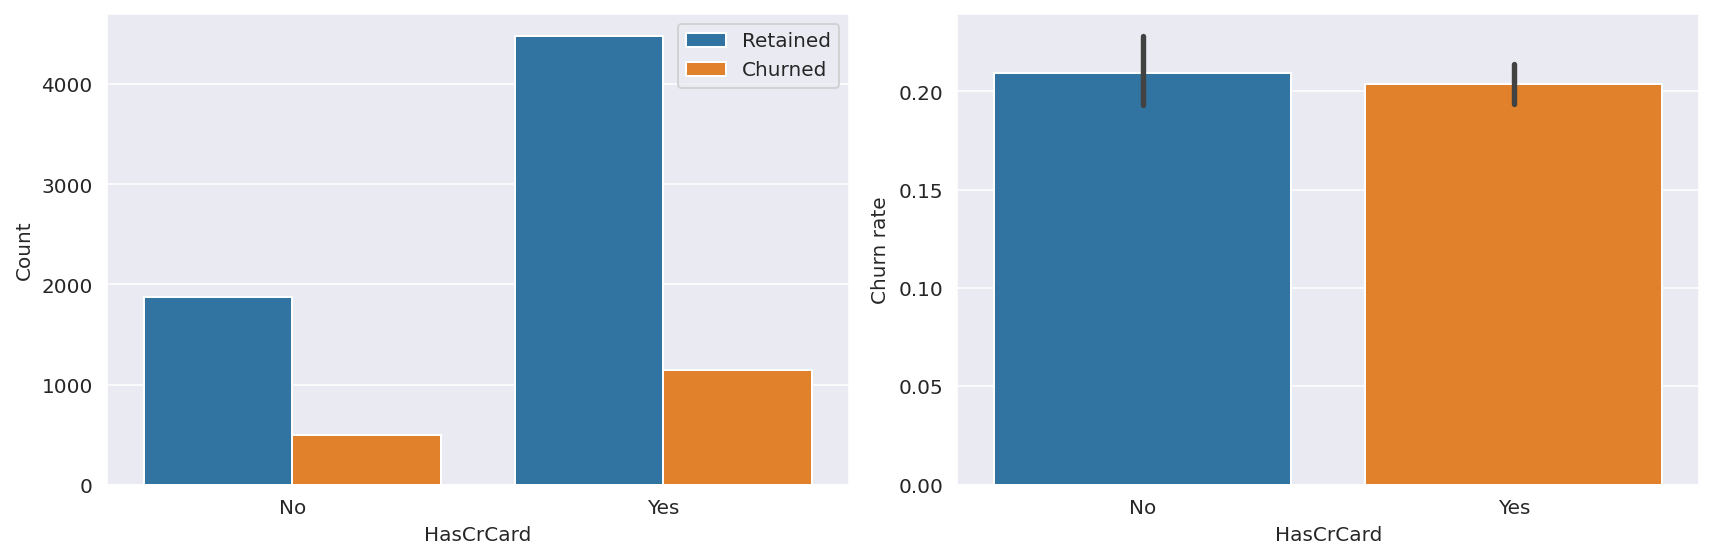

In [23]:
plot_categorical('HasCrCard')

Having a credit card does not seem to affect the churn rate.

### Active Members

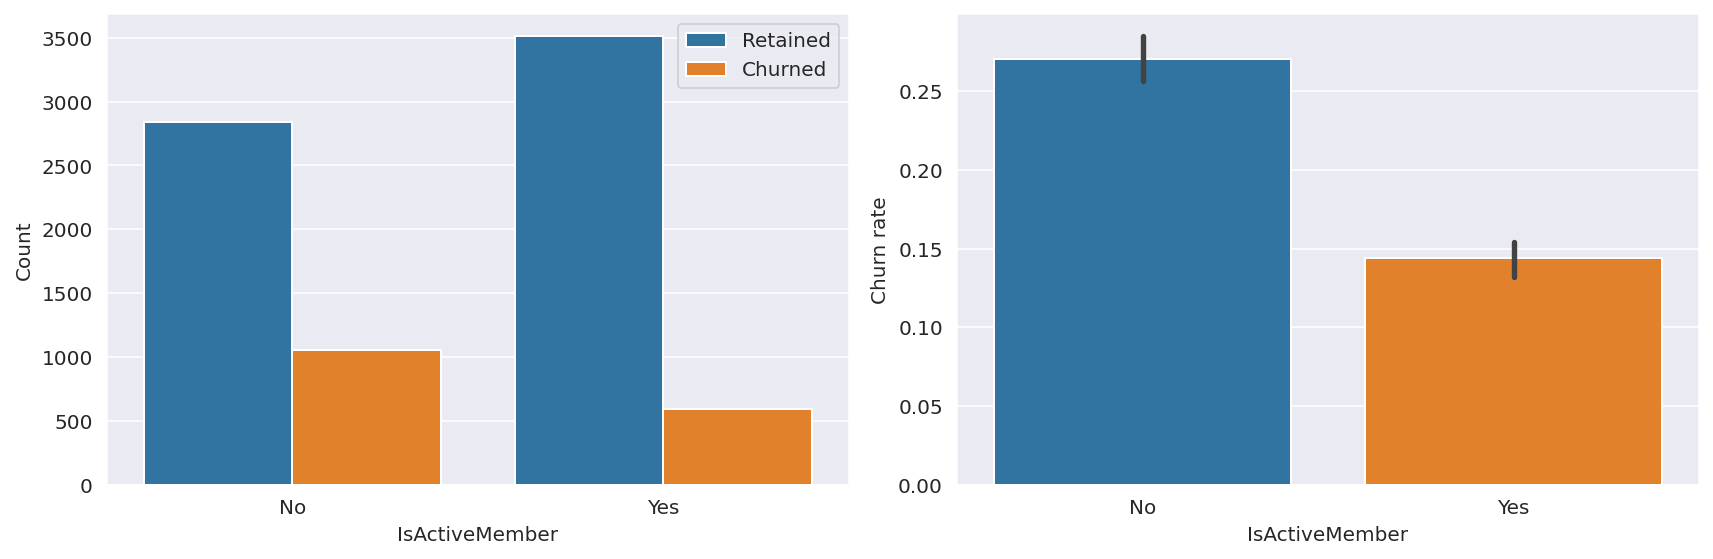

In [24]:
plot_categorical('IsActiveMember')

It's not a surprise that inactive customers are more likely to churn. A significant portion of the clientele is inactive; therefore, the bank will benefit from changing its policy so that more customers become active.

In [25]:
chi2_array= []
p_array = []

for column in categorical:
    crosstab = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({ 'Variable': categorical, 'Chi-square': chi2_array, 'p-value': p_array })
df_chi.sort_values(by='Chi-square', ascending=False)

,Variable,Chi-square,p-value
3,NumOfProducts,1233.595,3.767e-267
0,Geography,230.748,7.829e-51
5,IsActiveMember,195.315,2.199e-44
1,Gender,90.173,2.183e-21
2,Tenure,15.197,1.250e-01
4,HasCrCard,0.301,5.833e-01


## Encoding Categorical Features

In [26]:

for column in ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']:
    dummies = pd.get_dummies(train_df[column])
    train_df[dummies.columns] = pd.get_dummies(train_df[column])

# Drop features
features_drop = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
train_df = train_df.drop(features_drop, axis=1)



In [27]:
# Extracting the target feature
y_train = train_df['Exited']
X_train = train_df.drop('Exited', 1)

## SMOTE


In [28]:
over = SMOTE(sampling_strategy=0.5, random_state=42)
X_train, y_train = over.fit_resample(X_train, y_train)

print(y_train.value_counts() )


0    6356
1    3178
Name: Exited, dtype: int64


### Random Forest

In [29]:
# Plot a confusion matrix in the specified axes object
def plot_conf_mx(cm, ax):
    sns.heatmap(data=cm, annot=True, cmap='Blues', annot_kws={'fontsize': 30}, ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned'])

# Plot the learning curves for an estimator in the specified axes object
def plot_learning_curve(estimator, X, y, ax, cv=None, train_sizes=np.linspace(0.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='dodgerblue')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='darkorange')

    ax.plot(train_sizes, train_scores_mean, color='dodgerblue', marker='o', linestyle='-', label='Training Score')
    ax.plot(train_sizes, test_scores_mean, color='darkorange', marker='o', linestyle='-', label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14)

scoring_metric = 'recall'
comparison_dict = {}
comparison_test_dict = {}

# Display the overall performance of a classifier with this template

def clf_performance(classifier, classifier_name, classifier_name_abv):
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  cv=3,
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(y_train, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(y_train, y_pred),
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp), fpr, tpr
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)

    plt.tight_layout()




 Random Forest
-------------------------------
   Best Score (recall): 0.618
   Best Parameters: 
      bootstrap: True
      criterion: entropy
      max_depth: 6
      max_features: auto
      min_samples_leaf: 2
      min_samples_split: 2
      n_estimators: 100


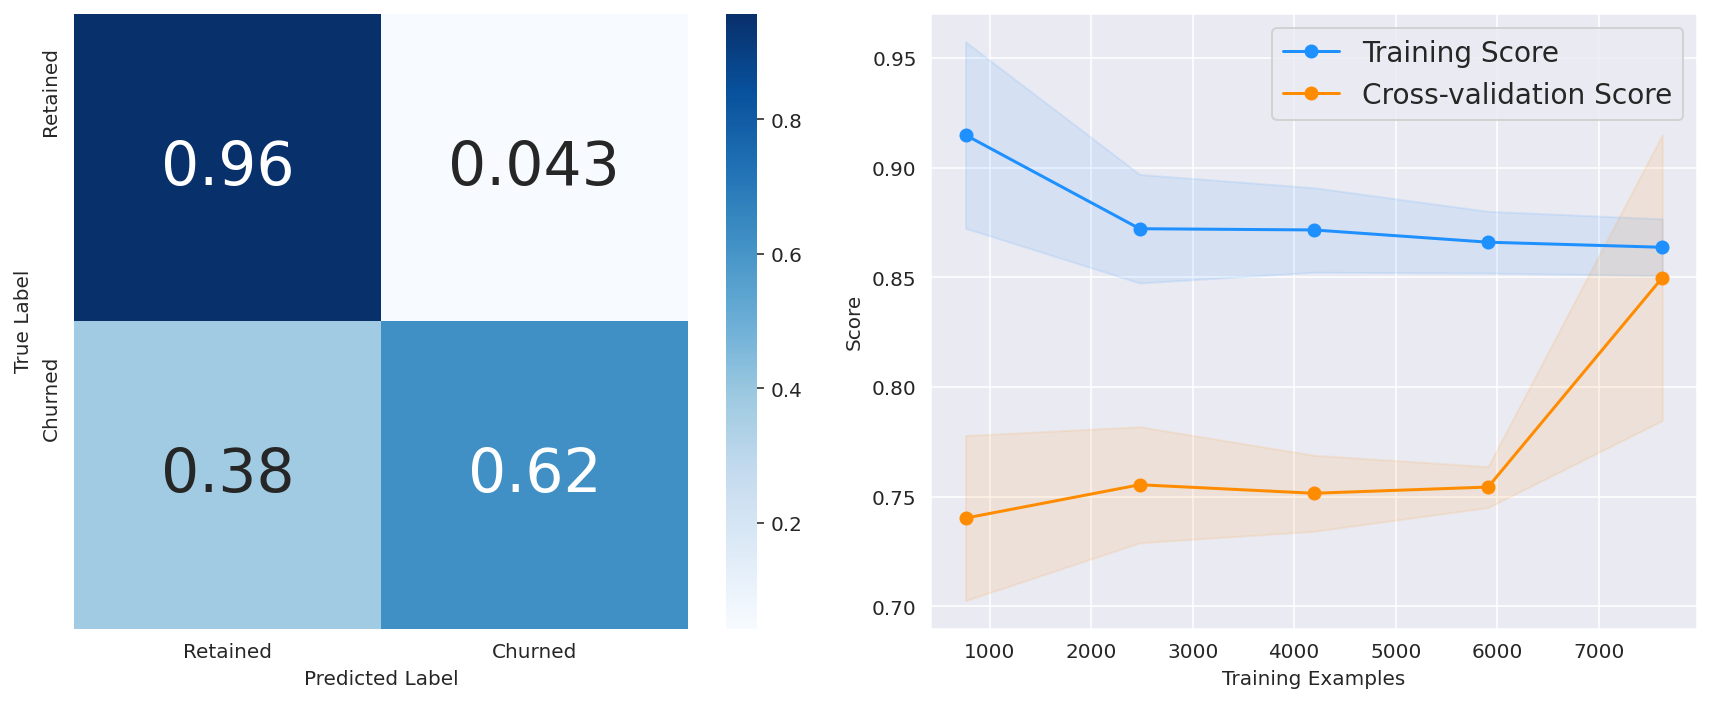

In [30]:
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

rf_clf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scoring_metric, cv=3, verbose=False, n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

### XGBoost Classifier


 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.607
   Best Parameters: 
      colsample_bytree: 0.75
      gamma: 0.1
      learning_rate: 0.01
      max_depth: 4
      min_child_weight: 1
      n_estimators: 50
      reg_alpha: 1
      reg_lambda: 1
      subsample: 0.5


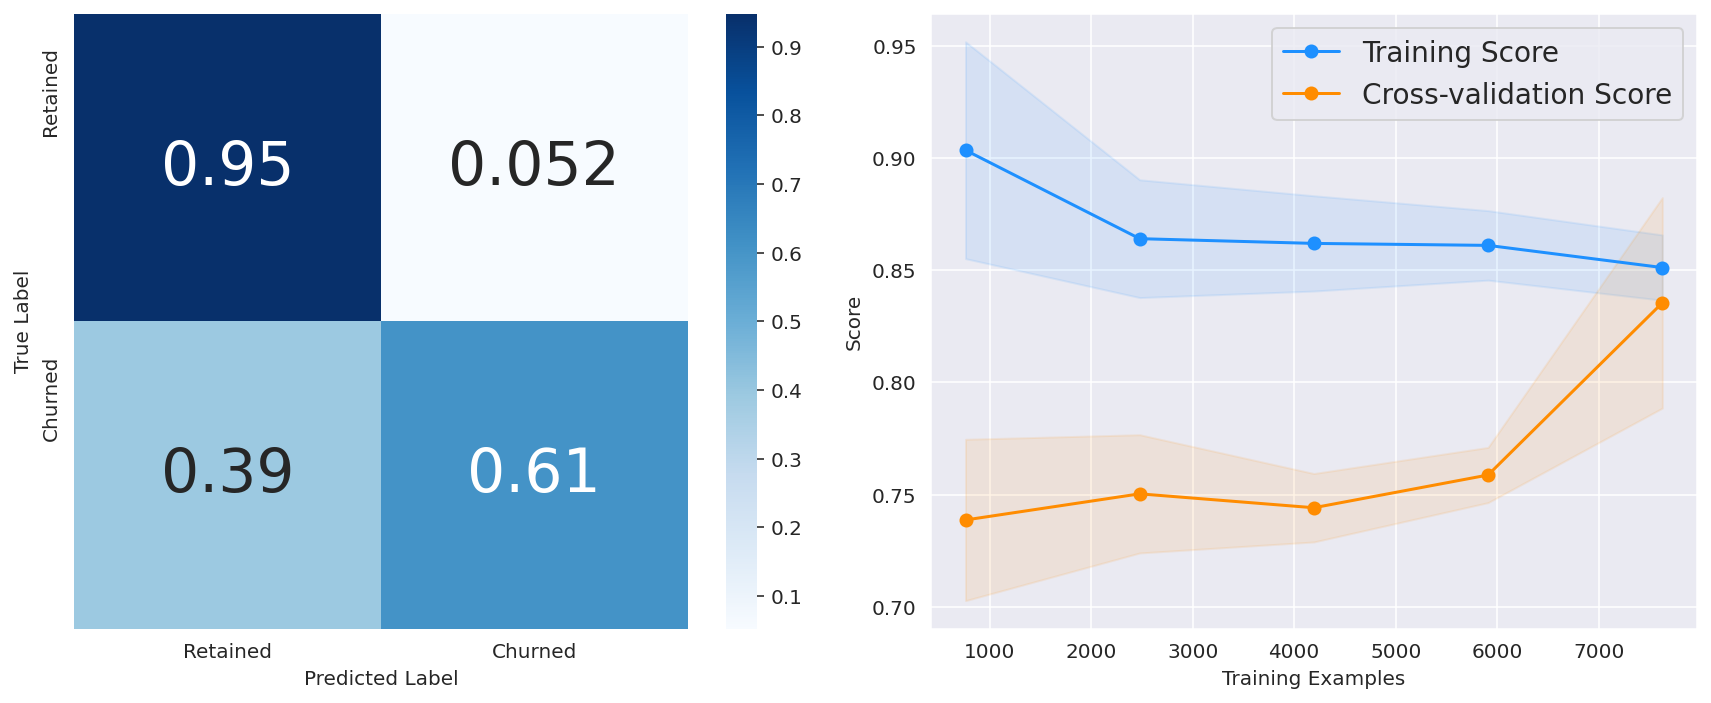

In [31]:
xgb = XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3, 4],  
    'reg_alpha': [1, 2],
    'reg_lambda': [1, 2],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 0.5, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=scoring_metric, cv=3, verbose=False, n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_train, y_train)
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB')

<br>

# Results

## Learning Curves

For all models, there is a tiny gap between the two curves at the end of training. This observation indicates that we do **not** overfit the training set. 

## Feature Importance

Some classifiers allow us to visualise feature importance:

In [44]:
# Plot the importance of features for a classifier as a barplot
def plot_feature_imp(classifier, classifier_name, color, ax):
    importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh( edgecolor='firebrick', legend=False, ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');


    

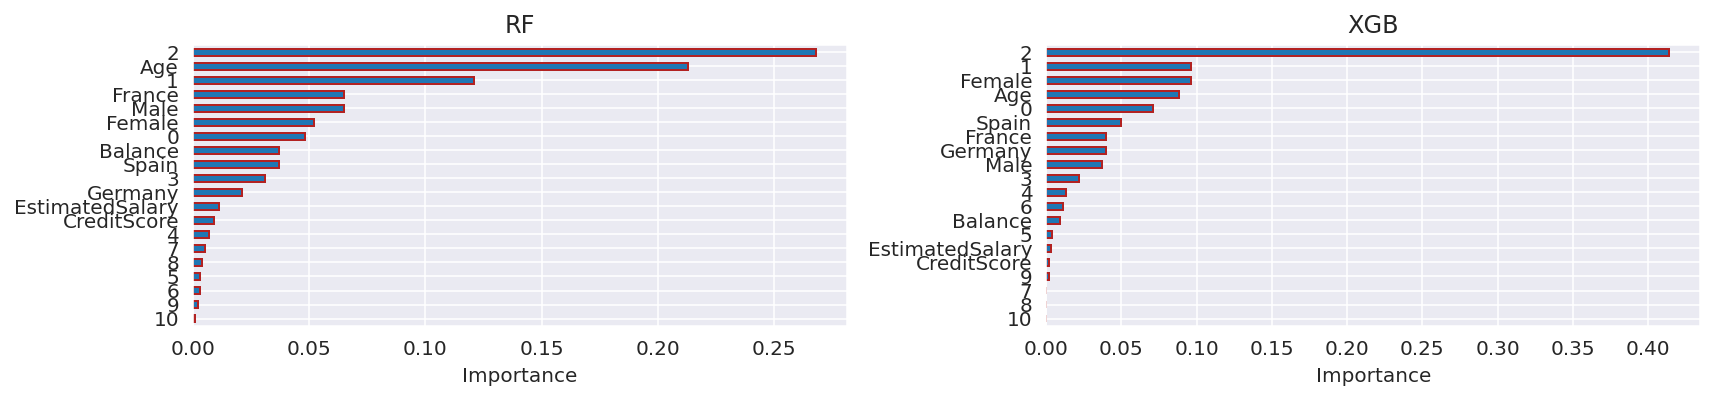

In [45]:

fig = plt.subplots(1, 2, figsize=(12, 5))

for i, (name, clf) in enumerate(zip(['RF', 'XGB'], [best_rf_clf, best_xgb_clf])):

    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, 'steelblue', ax)
    plt.ylabel('')

plt.tight_layout();

## Performance Comparison

In [34]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix, index=['Accuracy', 'Precision', 'Recall', 'AUC']).T


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

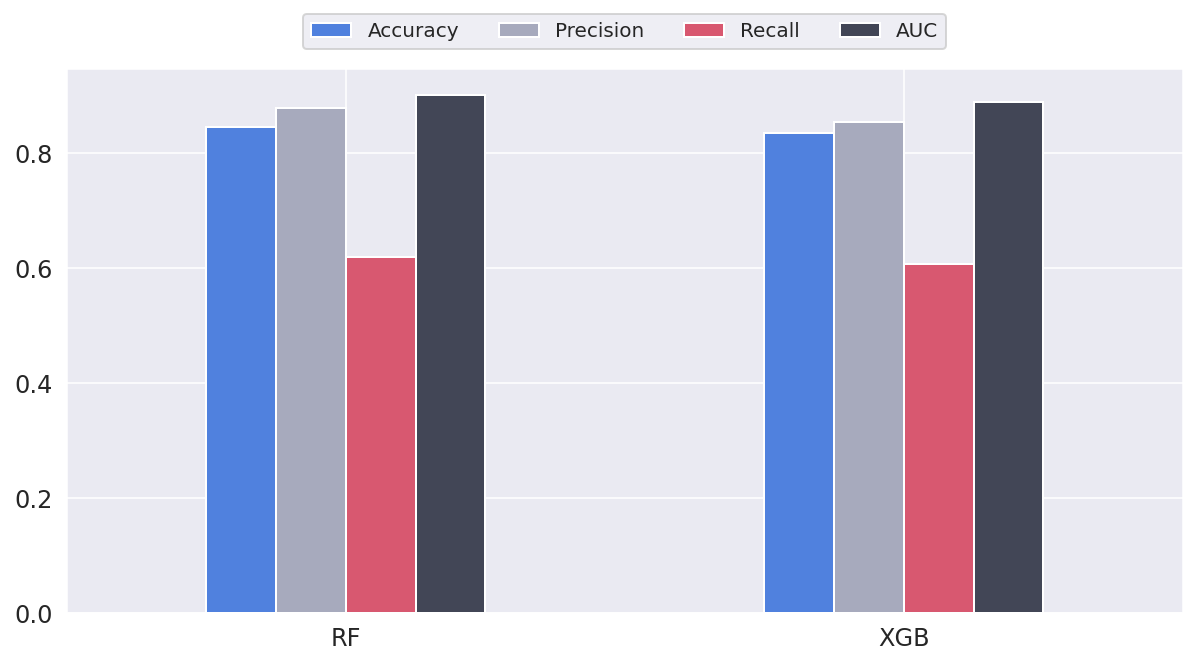

In [35]:
comparison_df.plot(kind='bar', figsize=(10, 5), fontsize=12, color=['#5081DE', '#A7AABD', '#D85870', '#424656'])

plt.legend(loc='upper center', ncol=len(comparison_df.columns), bbox_to_anchor=(0.5, 1.12))
plt.xticks(rotation=0)


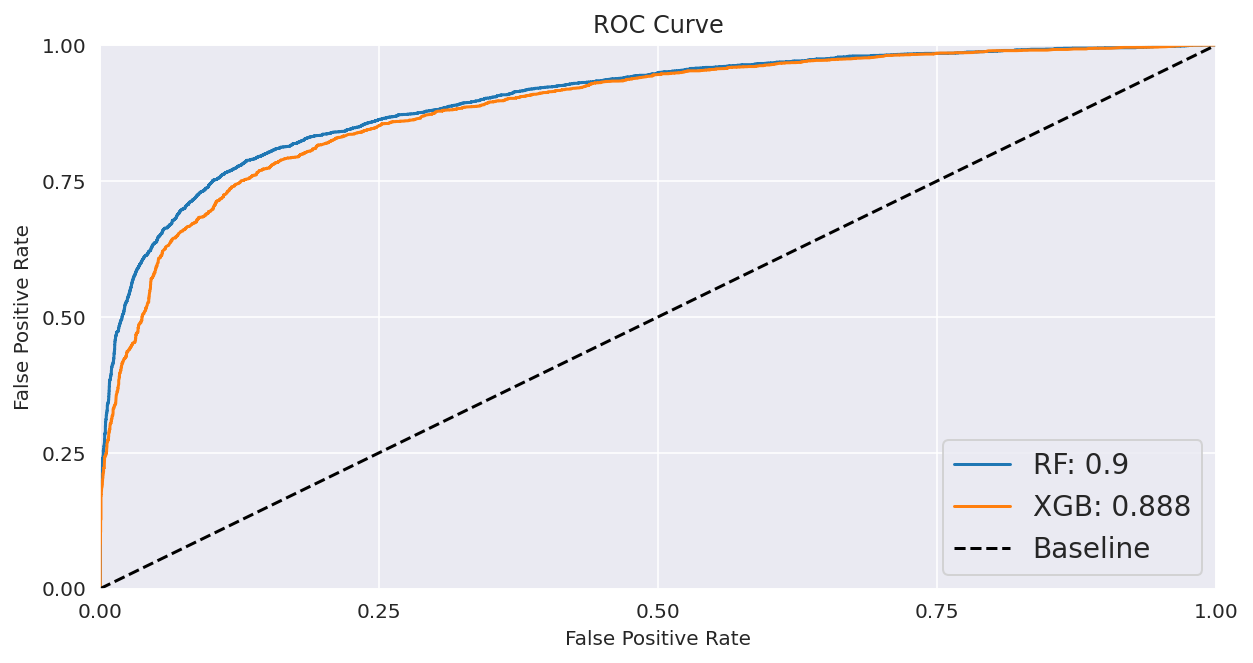

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))

for index, key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4], comparison_dict[key][5]
    ax.plot(fpr, tpr, label='{}: {}'.format(key, np.round(auc, 3)))

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('False Positive Rate')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.autoscale(axis='both', tight=True)
ax.legend(fontsize=14);

# Model Evaluation

In [57]:

for column in ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']:
    dummies = pd.get_dummies(test_df[column])
    test_df[dummies.columns] = pd.get_dummies(test_df[column])



# Drop features
features_drop = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
test_df = test_df.drop(features_drop, axis=1)


y_test = test_df['Exited']
X_test = test_df.drop('Exited', 1)

In [59]:
def test_func(classifier, classifier_name, ax):
    '''Assess the performance on the test set and plot the confusion matrix.'''
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

    sns.heatmap(cm, annot=True, annot_kws={'fontsize': 24}, cmap='Blues', ax=ax)

    ax.set_title(classifier_name)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])
    ax.set_yticklabels(['Retained', 'Churned'])

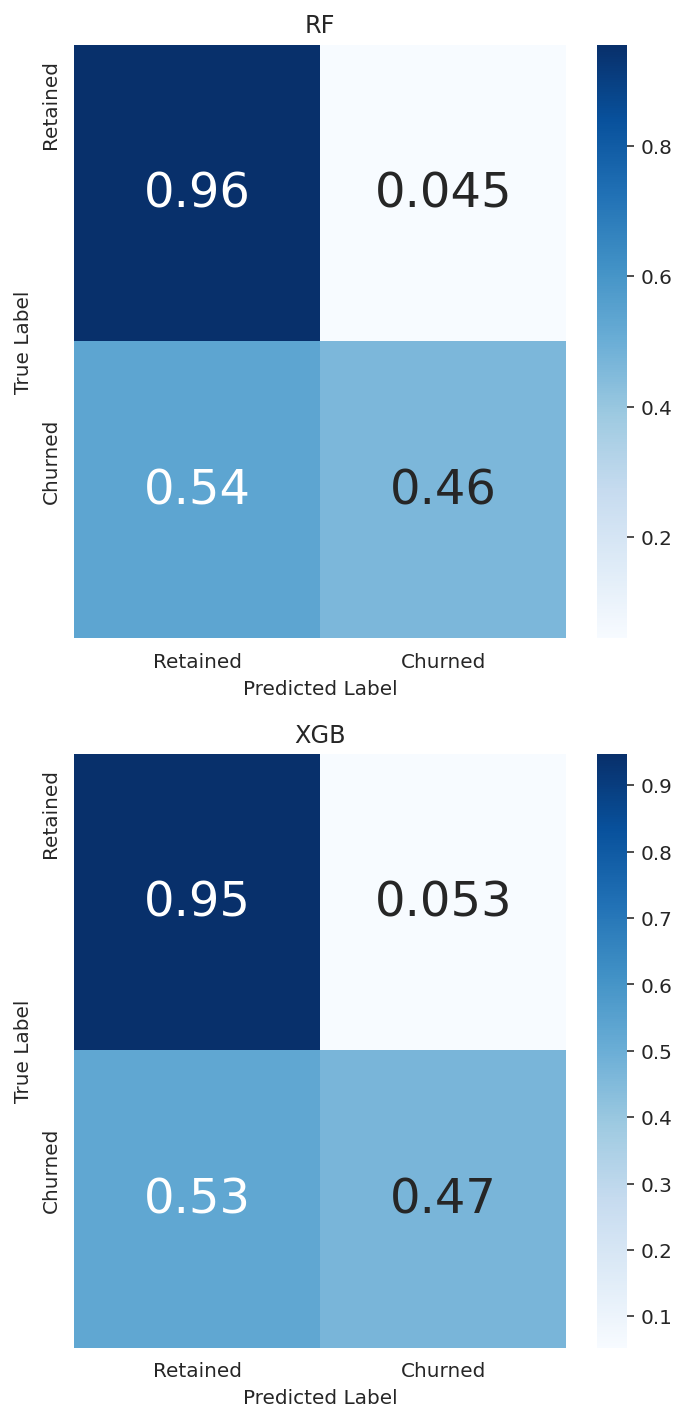

In [60]:
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

for i, (name, clf) in enumerate(zip(['RF','XGB'], 
                                    [best_rf_clf.best_estimator_, best_xgb_clf.best_estimator_])):
    test_func(clf, name, ax=ax[i])

plt.tight_layout();

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

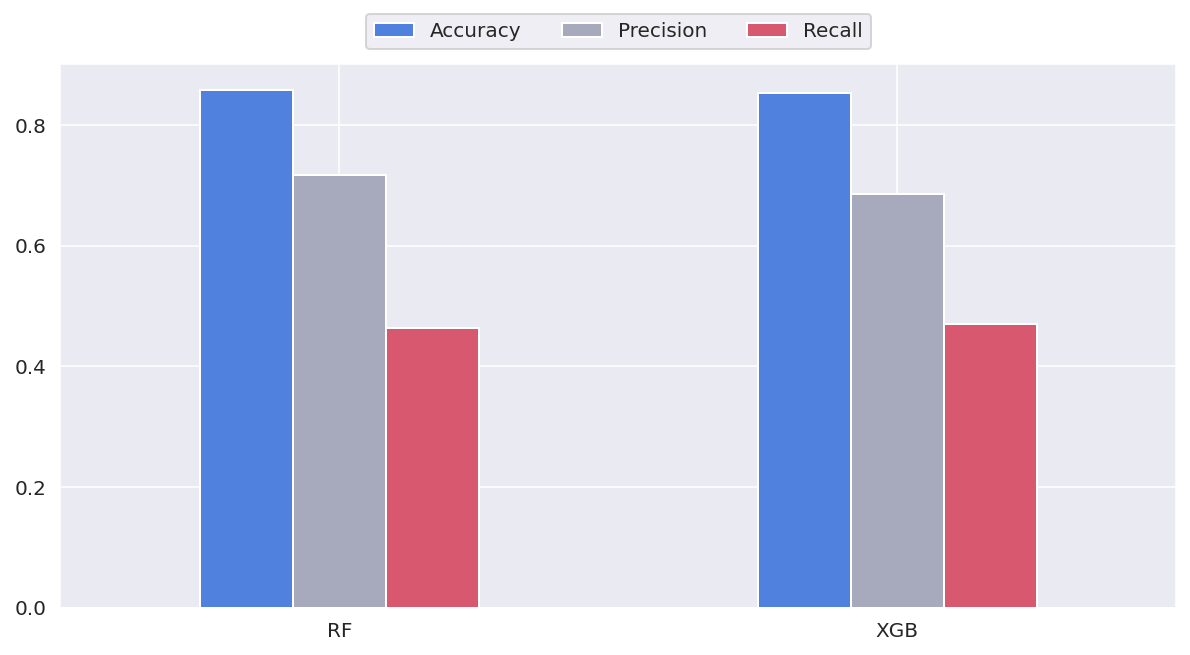

In [61]:
comparison_test_df = pd.DataFrame(comparison_test_dict,index=['Accuracy', 'Precision', 'Recall']).T

comparison_test_df.plot(kind='bar', figsize=(10, 5), color=['#5081DE', '#A7AABD', '#D85870'])

plt.legend(loc='upper center', ncol=len(comparison_test_df.columns), bbox_to_anchor=(0.5, 1.11))
plt.xticks(rotation=0)

